# Assignment 4 Generative Models

- now your task is generating data


- implement a variation of autoencoder "Variational Autoencoder" and a Generative Adversiarial Network


- employ both to create never-before seen handwritten digits

In [5]:
from utility import show, interpolate, plot_inter_embed
import torch
from torch import optim, nn
from torch.nn.functional import relu
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
import torchvision.transforms.functional as F 
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import scprep
from phate import PHATE 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import imageio
import os
from time import perf_counter
import scipy
from sklearn.neighbors import KernelDensity
from pyemd import emd_samples

# variational autoencoder

- Autoencoders are great, but their latent spaces can be messy


- AE's embedding of MNIST clumped each digit into separate islands, with some overlap but also large empty regions

    - the points in these empty parts of embedding don't correspond well to real digits


- this is founding idea of Variational Autoencoder,

    makes 2 changes to make interpolation within latent space more meaningful
    

- change 1: encourage similar latent repre within clusters

    encoder: instead of encoding points in a latent space, creates a Gaussian probability distribution around encoded point, with mean $\mu$ and variance $\sigma^2$ unique to each point
    
    decoder: pass a random sample from this distribution, encourages similar points in latent space to correspond to similar outputs, since decoder only gets to choose a point close to encoded original
    
    

- change 2: enforce proximity between clusters

    achieved by KL divergence: tabulates dissimilarity of previously generated Gaussian with a standard Normal distribution
    
    measure how much $\sigma^2$ and $\mu^2$ differ from a variance of 1 and mean of 0
    
    prevents any class of embeddings from drifting too far away from the others
 

- KL divergence between 2 Normal distributions:

$$
D_{KL}[N(\mu, \sigma) || N(0, 1)] =\frac{1}{2} \sum (1 + \log \sigma^2 - \mu^2 - \sigma^2)
$$

where sum is taken over each dim in latent space

- reading:

    - intro to Variational Autoencoders: "Generative Deep Learning" 
    
        https://learning.oreilly.com/library/view/generative-deep-learning/9781492041931/ch03.html
    
    - math theory: “Auto-encoding Variational Bayes” 
    
        https://arxiv.org/pdf/1312.6114

    - https://www.jeremyjordan.me/variational-autoencoders/


    - https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

1. complete TODOs in `vae.py` to build a variational autoencoder (VAE)

    complete function `VAE_loss_function` 
    
    by summing reconstruction loss use Mean Squarred Error
    
    with a regularization given by KL-divergence as a function of sigma and mu
    
    
2. train your VAE on MNIST

    how well does it perform on test set relative to your vanilla autoencoder?
    
    you can run VAE by `python vae.py --arguments here`
    
    
3. visualize latent space as a 2D plot, colored by label

    since our VAE uses a 2D dim latent space, you can try some dim reduction methods (PCA, PHATE, tSNE) to get a coherent 2D repre
    
    
4. interpolate between 2 different images in latent space

    run embedding thr decoder to generate a never-before seen digit
    
    - interpolate between digits of same class
    
    - interpolate between digits of different class

## model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.nn.ReLU(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std) # noise sample from N(0, 1)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.nn.ReLU(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## loss 

In [ ]:
def VAE_loss_function(recon_x, x, mu, logvar):
    # TO DO: Implement reconstruction + KL divergence losses summed over all elements and batch

    # for additional information on computing KL divergence
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    recon_loss = torch.nn.binary_cross_entropy(recon_x, x.reshape(-1, 784), reduction='sum')
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + KLD

## training

In [ ]:
# checkpoint4.pt: train VAE  12 min
# The minimum test loss of 100.764 occurred after epoch 93.
!python vae.py --epochs 100

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.513977
Train Epoch: 1 [1280/60000 (2%)]	Loss: 310.610535
Train Epoch: 1 [2560/60000 (4%)]	Loss: 240.650162
Train Epoch: 1 [3840/60000 (6%)]	Loss: 219.223129
Train Epoch: 1 [5120/60000 (9%)]	Loss: 215.093201
Train Epoch: 1 [6400/60000 (11%)]	Loss: 208.448837
Train Epoch: 1 [7680/60000 (13%)]	Loss: 203.371399
Train Epoch: 1 [8960/60000 (15%)]	Loss: 193.754959
Train Epoch: 1 [10240/60000 (17%)]	Loss: 194.702850
Train Epoch: 1 [11520/60000 (19%)]	Loss: 192.928146
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.929642
Train Epoch: 1 [14080/60000 (23%)]	Loss: 174.044189
Train Epoch: 1 [15360/60000 (26%)]	Loss: 182.588226
Train Epoch: 1 [16640/60000 (28%)]	Loss: 168.161835
Train Epoch: 1 [17920/60000 (30%)]	Loss: 166.464920
Train Epoch: 1 [19200/60000 (32%)]	Loss: 161.464157
Train Epoch: 1 [20480/60000 (34%)]	Loss: 162.524490
Train Epoch: 1 [21760/60000 (36%)]	Loss: 151.496918
Train Epoch: 1 [23040/60000 (38%)]	Loss: 157.338165
Train Epoch: 1 [24320/60000 

## visualize 2D embeddings

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# load trained variational autoencoder
model = VAE().to(device)
checkpoint = torch.load("/content/checkpoint4.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
# load training set
mnist_train = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor()) 
# load test set 
mnist_test = datasets.MNIST(root='data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor()) 

batch_size = 128                      
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

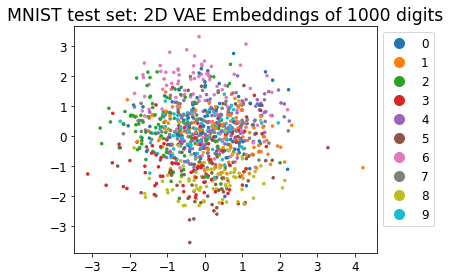

In [ ]:
# visualize 2D VAE Embeddings of 1000 digits in MNIST test set
data_loader = torch.utils.data.DataLoader(mnist_test, batch_size = 1000, shuffle = True)
 
with torch.no_grad():
    for data, targets in data_loader:
        data = data.to(device)
        model_input = data.reshape(-1, 784)
        mu, logvar = model.encode(model_input)
        out = model.reparameterize(mu, logvar)
        embeddings = out.detach().cpu().numpy() 
        labels = targets.numpy()
        break

scprep.plot.scatter2d(embeddings, c = labels, 
                          title="MNIST test set: 2D VAE Embeddings of 1000 digits",
                          legend_anchor=(1,1))  

## dim reduction

since our VAE uses a 2D dim latent space, you can try some dim reduction methods (PCA, PHATE, tSNE) to get a coherent 2D repre

### PCA

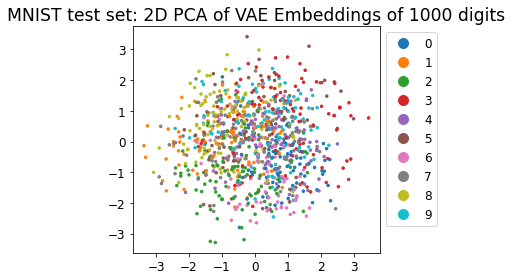

In [ ]:
# visualize 2D PCA Embeddings of 1000 digits in MNIST test set
pca_embeddings = scprep.reduce.pca(embeddings, n_components=2, method='dense')

scprep.plot.scatter2d(pca_embeddings, c = labels, 
                          title="MNIST test set: 2D PCA of VAE Embeddings of 1000 digits",
                          legend_anchor=(1,1))  

### PHATE

Calculating PHATE...
  Running PHATE on 1000 observations and 20 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 0.69 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.03 seconds.
Calculated PHATE in 2.30 seconds.


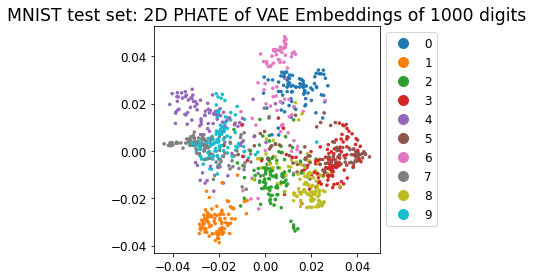

In [ ]:
# visualize 2D PHATE Embeddings of 1000 digits in MNIST test set

phate_embeddings = PHATE().fit_transform(embeddings)

scprep.plot.scatter2d(phate_embeddings, c = labels, 
                          title="MNIST test set: 2D PHATE of VAE Embeddings of 1000 digits",
                          legend_anchor=(1,1))  

### t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


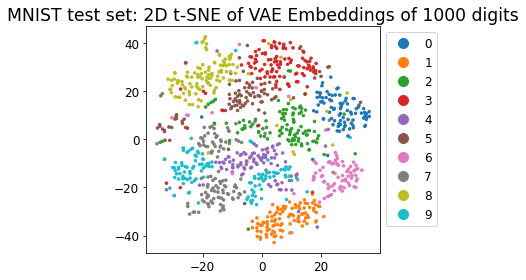

In [ ]:
# visualize 2D t-SNE Embeddings of 1000 digits in MNIST test set
tsne_embeddings = TSNE().fit_transform(embeddings)
scprep.plot.scatter2d(tsne_embeddings, c = labels, 
                          title="MNIST test set: 2D t-SNE of VAE Embeddings of 1000 digits",
                          legend_anchor=(1,1))  

### fabricated embedding

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


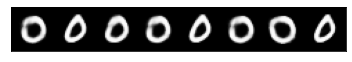

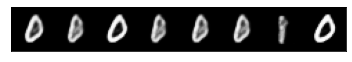

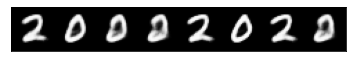

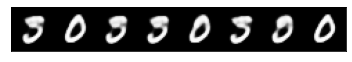

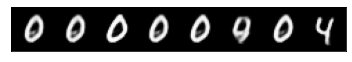

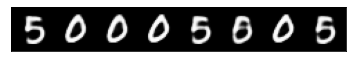

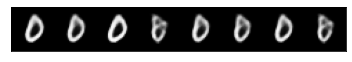

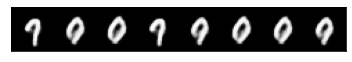

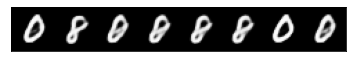

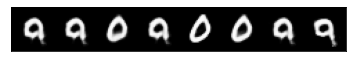

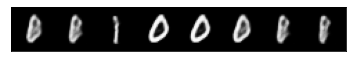

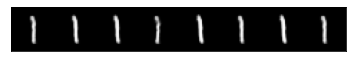

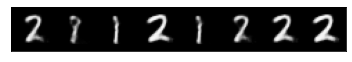

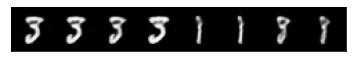

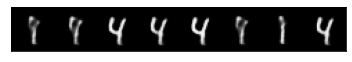

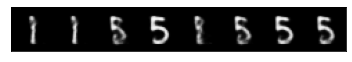

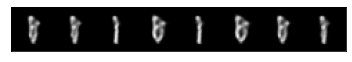

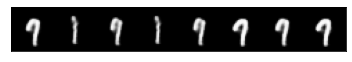

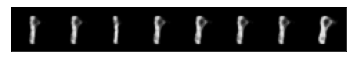

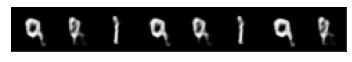

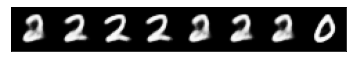

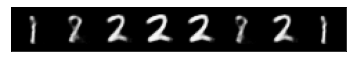

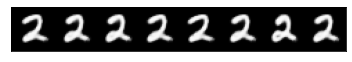

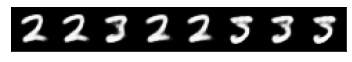

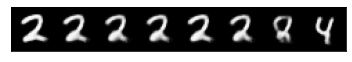

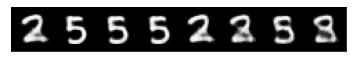

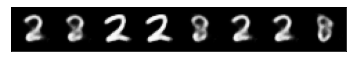

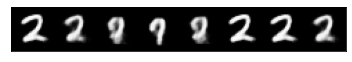

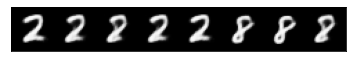

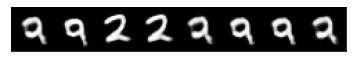

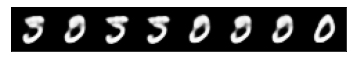

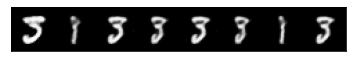

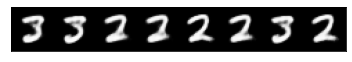

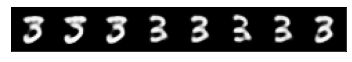

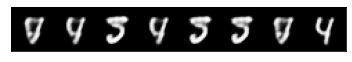

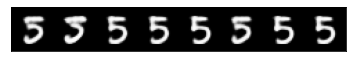

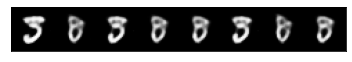

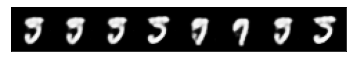

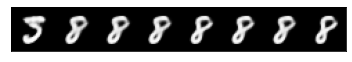

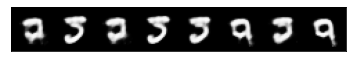

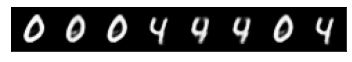

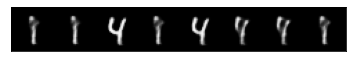

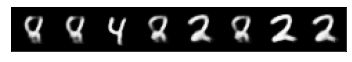

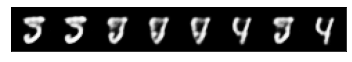

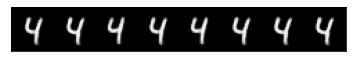

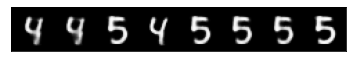

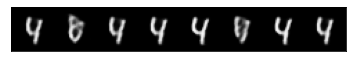

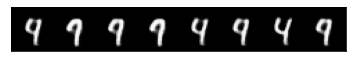

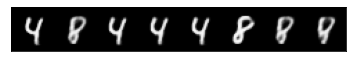

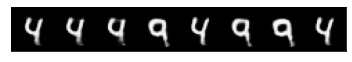

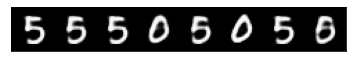

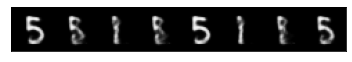

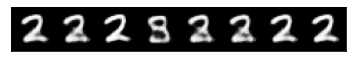

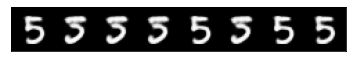

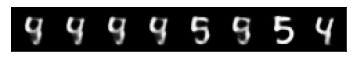

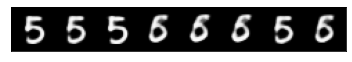

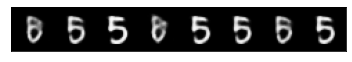

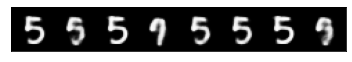

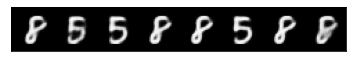

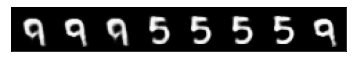

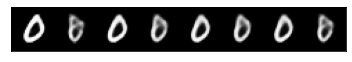

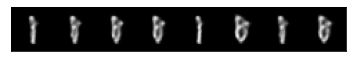

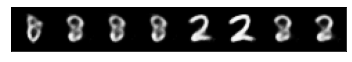

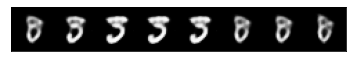

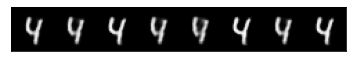

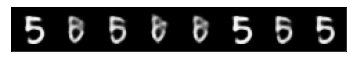

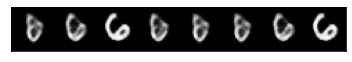

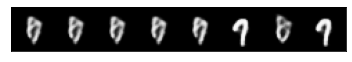

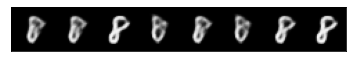

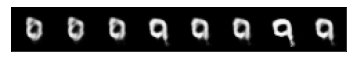

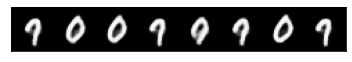

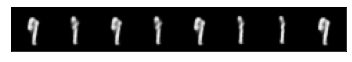

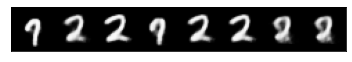

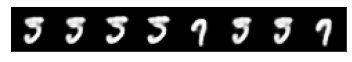

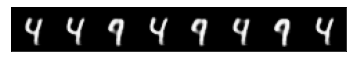

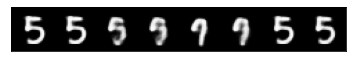

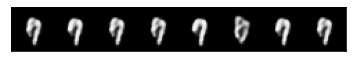

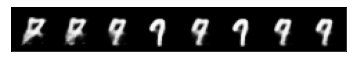

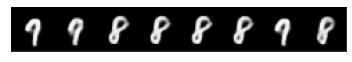

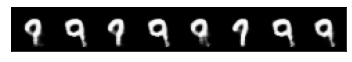

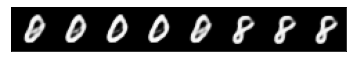

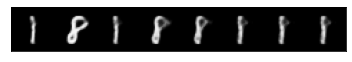

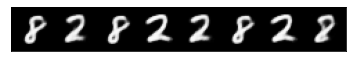

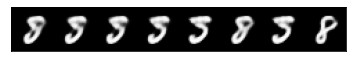

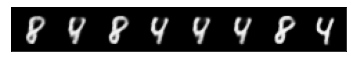

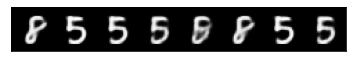

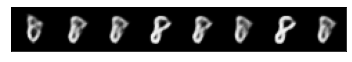

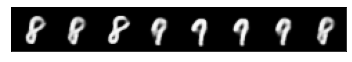

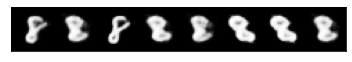

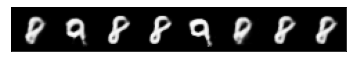

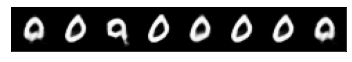

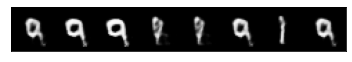

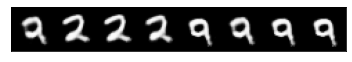

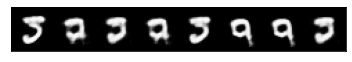

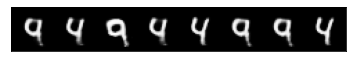

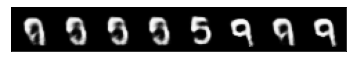

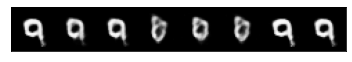

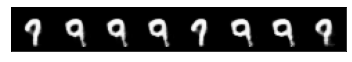

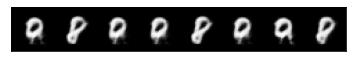

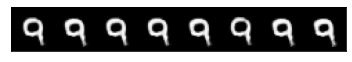

In [ ]:
for i in range(10):
  for j in range(10):
    # print(f"label 1 = {i}, label 2 = {j}")
    _ = interpolate(embeddings, model, labels, n=8, label1=i, label2=j) 


#### between classes

In [ ]:
label1 = 3
label2 = 1

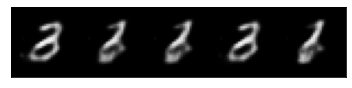

In [ ]:
# interpolate an embedding from digit 3 and digit 1
img1, img2, inter_embed = interpolate(embeddings, model, labels, n=5, label1=label1, label2=label2) 

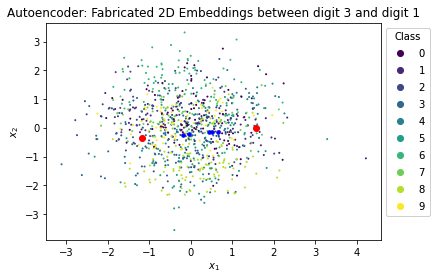

In [ ]:
plot_inter_embed(embeddings, img1, img2, inter_embed, classes="between")

#### within classes

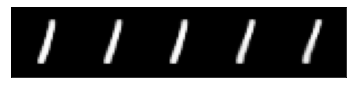

In [ ]:
label1 = 1
label2 = 1

img1, img2, inter_embed = interpolate(embeddings, model, labels, n=5, label1=label1, label2=label2) 

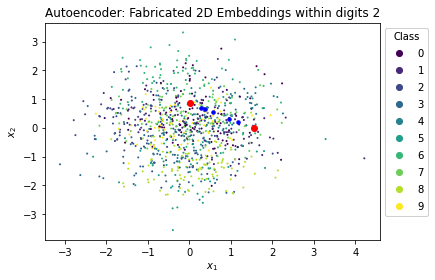

In [ ]:
plot_inter_embed(embeddings, img1, img2, inter_embed, classes="within")

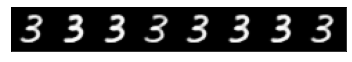

In [ ]:
interpolate(embeddings, n=8, label1=3, label2=3) 

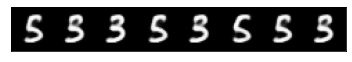

In [ ]:
interpolate(embeddings, n=8, label1=3, label2=5)

## discussion

- how does VAE's latent space compare to latent space of your previous autoencoder?


- do generated images have more clarity?


- is this most noticeable between/within classes?

Both VAE's latent space alone and PCA embeddings of VAE don't separate classes better than previous autoencoder. But PHATE embeddings and t-SNE embeddings of VAE separate classes better than previous autoencoder, and t-SNE performs better than PHATE. It's most noticeable between classes.

- in what situations would a VAE be more useful than a vanilla autoencoder?


- when would you prefer a vanilla autoencoder to a VAE?

If we want to generate new images, VAE is more useful than a vanilla autoencoder because for an image input, vanilla autoencoder will always produce the same reconstructed image. And VAE is better in learning a meaningful latent space than vanilla autoencoder.

If I want to do clustering analysis, i.e., classify between classes, I would choose vanilla autoencoder, because the KL Divergence regularization term of objective function of VAE imposes similarity between classes, which isn't good for separating different classes.

- distance between embeddings in your first autoencoder provided some measure of similarity between digits


- to what extent is this preserved/improved by VAE?

The distance between embeddings in VAE encoded more meaningful measure of similarity between digits. VAE encourages similar latent representations within clusters by sampling from a Gaussian distribution, and prevent different clusters from drifting too far away from the others by KL Divergence regularization term.

# GAN

Q: What if the discriminator loss is going down too fast?

A. Try a higher learning rate for the generator. 

reference

- https://github.com/juliechchang/cs231n-hw3/blob/master/GANs-PyTorch.ipynb


- https://d2l.ai/chapter_generative-adversarial-networks/gan.html#generator

- though VAE was tweaked to allow small perturbations in latent space to produce reasonable decodings


- Generative Adversarial Network (GAN) was designed to generate novel samples


- a GAN combines 2 nets in 1:

    - generator net: produce fake images
    
    - discriminator: guess if they are fake


- initially, both nets perform horribly, 

    but with time and luck they enforce each other to improve until the generator's images are indistinguishable from real thing
    
    
- build your own GAN in PyTorch, test it on MNIST dataset

![gan.svg](https://d2l.ai/_images/gan.svg)

1. in `GAN.py`, 


- fill in `train_generator` function (training function for generator)

    run generator, compute generator's loss
    
- simplest formula:
    
    create a zero-sum (or minimax) game by setting 
    
$$
\mathbb{L}^{(G)}=-\mathbb{L}^{(D)}
$$
    
but this doesn't train well: if discriminator finds an easy way to recognize forgeries, the generator's loss also goes to 0 and gradients vanish
    
- a more reliable formula:
    
$$
\mathbb{L}^{(G)}=-\frac{1}{2}\mathbb{E}_z \log D(G(z))
$$

- fill in `train_discriminator` function (training function for discriminator)
   
   run discriminator, then compute discriminator's loss
   
$$
\mathbb{L}^{(D)}=-\frac{1}{2}\mathbb{E}_{x \text{~ data}} \log D(x) - \frac{1}{2}\mathbb{E}_{z \text{~ noise}} \log (1-D(G(z)))
$$

where x is a training sample

z is input to generator

this is just standard cross entropy loss but with 2 terms

1st term: ensures that discriminator can recognize real samples as real

2nd term: motivates discriminator to classify output of generator as fake

2. create a training loop for your newly created GAN

    both nets now train simultaneously
    
    run some random noise through generator to create a batch of fake samples
    
    then passing the batch of fake and real samples thru `train_generator` function and `train_discriminator` function to compute corresponding loss， then backpropogate the loss, perform an optimization step,
    
    Note: before passing generated noise into `train_discriminator` function, 
    
    run `fake_data.detach()` to remove redundant gradients generated by generator's optimization step

If you are not seeing that your GAN is progressing at all (no number-looking images are being generated), try this in your training  loop:

1. Start off each batch by generating fake data and detaching it, as in:

```
fake_data = generator(noise)
fake_data=fake_data.detach()
```

2. Train the discriminator with this fake data.


3. Generate new noise and new fake data, but don't detach, as in:

```
fake_data = generator(noise2)
fake_data=fake_data
```

4. Train the generator.

3. train GAN for 100 epochs or more

    after each epoch, visualize generated images
    
    **include some of images from different epochs in report**

4. after training GAN, generate 1000 sample digits, include some of images in report

    save these generations for later use by `torch.save`

5. use best performing classifier `feed-forward` net from Part 2 to classify these samples

## model

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # the dimension of the random noise used to seed the Generator
        self.main = nn.Sequential( # nn.sequential is a handy way of combining multiple layers.
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

## training function

### discriminator

In [ ]:
def train_discriminator(discriminator, criterion, optimizer, real_data, fake_data):
    """
    Train the discriminator on a minibatch of data.
    INPUTS
        :param optimizer: the optimizer used for training
        :param real_data: the batch of training data
        :param fake_data: the data generated by the generator from random noise
    The discriminator will incur two losses: one from trying to classify the real data, and another from classifying the fake data.
    TODO: Fill in this function.
    It should
    1. Run the discriminator on the real_data and the fake_data
    2. Compute and sum the respective loss terms (described in the assignment)
    3. Backpropogate the loss (e.g. loss.backward()), and perform optimization (e.g. optimizer.step()).
    """
    batch_size = real_data.shape[0]
    
    # zero out the gradients
    optimizer.zero_grad()

    # feed real data into discriminator to get output
    real_out = discriminator(real_data)

    # feed fake data into discriminator to get output
    fake_out = discriminator(fake_data) 

    # generate labels of real data (1)
    real_label = torch.ones((batch_size, ), device=device).reshape(real_out.shape)

    # generate labels of fake data (0)
    fake_label = torch.zeros((batch_size, ), device=device).reshape(fake_out.shape)


    # compute discriminator loss
    loss = 0.5 * (criterion(real_out, real_label) + criterion(fake_out, fake_label))

    # Backpropogate the loss
    loss.backward()

    # perform a step of optimization
    optimizer.step()

    # we'll return the loss for book-keeping purposes. (E.g. if you want to make plots of the loss.)
    return loss


### generator

In [ ]:
def train_generator(discriminator, criterion, optimizer, fake_data):
    """
    Performs a single training step on the generator.
    :param optimizer: the optimizer
    :param fake_data: forgeries, created by the generator from random noise. (Done before calling this function.)
    :return:  the generator's loss
    TODO: Fill in this function
    It should
    1. Run the discriminator on the fake_data
    2. compute the resultant loss for the generator (as described in the assignment)
    3. Backpropagate the loss, and perform optimization
    """
    batch_size = fake_data.shape[0]
 
    # zero out the gradients
    optimizer.zero_grad()

    # feed fake data into discriminator to get output
    fake_out = discriminator(fake_data)

    # generate labels of fake data (1)
    fake_label = torch.ones((batch_size, ), device=device).reshape(fake_out.shape)
   
    # compute generator loss
    loss = 0.5* criterion(fake_out, fake_label)

    # Backpropagate the loss
    loss.backward()

    # perform a step of optimization
    optimizer.step()

    return loss


## training

In [ ]:
# import training data
train_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transforms.ToTensor())

batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
num_epochs = 100

# initialize geneartor and discriminator
nz = 25 # dimension of random noise
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

# initialize binary cross entropy loss 
criterion = nn.BCELoss(reduction='mean')

# initialize Adam optimizer
lr_D, lr_G = 1e-3, 1e-3 # a higher learning rate for generator
g_optimizer = optim.Adam(generator.parameters(), lr_G, betas=(0.5, 0.999)) 
d_optimizer = optim.Adam(discriminator.parameters(), lr_D, betas=(0.5, 0.999))
g_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=5, gamma=0.1)
d_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=5, gamma=0.1)

Epoch: 0 Generator loss: 1.7766	 Discriminator loss: 0.3469
Epoch: 5 Generator loss: 1.3903	 Discriminator loss: 0.5159
Epoch: 10 Generator loss: 1.4817	 Discriminator loss: 0.4383
Epoch: 15 Generator loss: 6.1258	 Discriminator loss: 0.8085
Epoch: 20 Generator loss: 1.7887	 Discriminator loss: 0.4011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Epoch: 25 Generator loss: 2.1802	 Discriminator loss: 0.3577
Epoch: 30 Generator loss: 1.7695	 Discriminator loss: 0.5358
Epoch: 35 Generator loss: 1.3863	 Discriminator loss: 0.6307
Epoch: 40 Generator loss: 1.5539	 Discriminator loss: 0.4580
Epoch: 45 Generator loss: 1.0608	 Discriminator loss: 0.5966


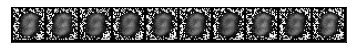

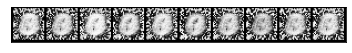

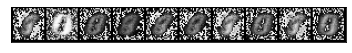

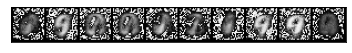

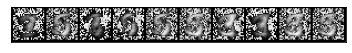

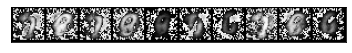

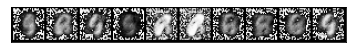

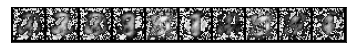

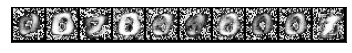

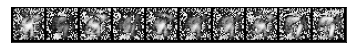

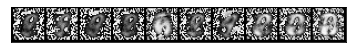

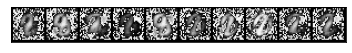

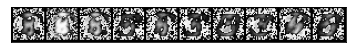

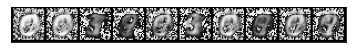

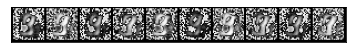

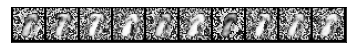

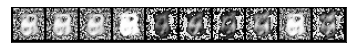

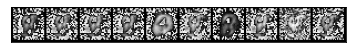

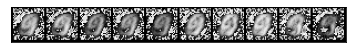

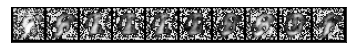

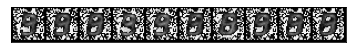

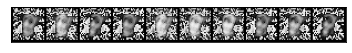

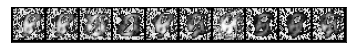

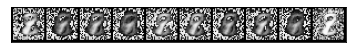

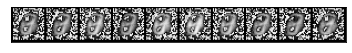

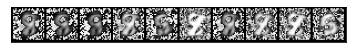

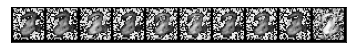

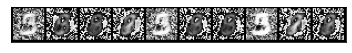

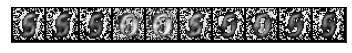

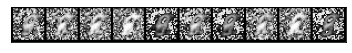

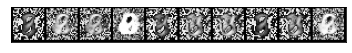

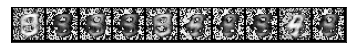

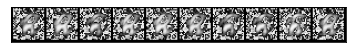

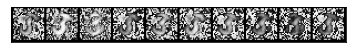

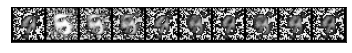

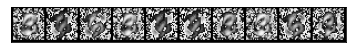

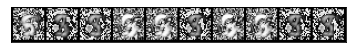

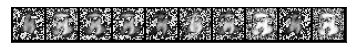

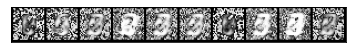

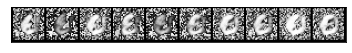

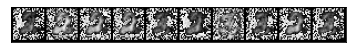

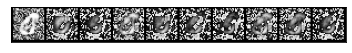

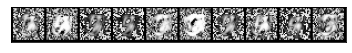

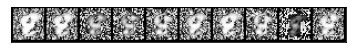

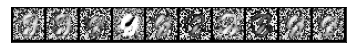

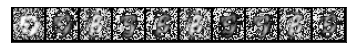

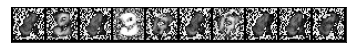

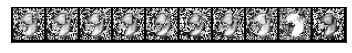

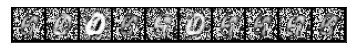

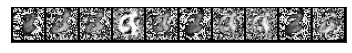

In [ ]:
#TODO: Build a training loop for the GAN
# For each epoch, you'll
# 1. Loop through the training data. For each batch, feed random noise into the generator to generate fake_data of the corresponding size.
# 2. Feed the fake data and real data into the train_discriminator and train_generator functions
# At the end of each epoch, use the below functions to save a grid of generated images.
d_epoch_loss, g_epoch_loss = np.zeros(num_epochs), np.zeros(num_epochs)

for epoch in range(num_epochs):
    d_batch_loss, g_batch_loss = np.zeros(len(train_loader)), np.zeros(len(train_loader))
    for data, _ in train_loader:
        # perform training
        data = data.to(device)

        # generate random noise
        noise = torch.normal(0, 1, size=(batch_size, nz)).to(device)

        # feed random noise into the generator to generate fake data
        fake_data = generator(noise)

        # first update the discriminator and then the generator
        # train discriminator, Do not need to compute gradient for generator, detach it from computing gradients.
        d_batch_loss[i] = train_discriminator(discriminator, criterion, d_optimizer, data, fake_data.detach()).item()

        # generate new random noise
        noise2 = torch.normal(0, 1, size=(batch_size, nz)).to(device)

        # feed random noise into the generator to generate fake data
        fake_data = generator(noise2)

        # train generator
        g_batch_loss[i] = train_generator(discriminator, criterion, g_optimizer, fake_data).item()
      
    d_epoch_loss[epoch] = np.mean(d_batch_loss)
    g_epoch_loss[epoch] = np.mean(g_batch_loss)

    d_scheduler.step()
    g_scheduler.step() 

    if epoch % 5 == 0:
      print("Epoch: {} Generator loss: {:.4f}\t Discriminator loss: {:.4f}".format(epoch, g_epoch_loss[epoch], d_epoch_loss[epoch]))

    # generate new random noise
    noise = torch.normal(0, 1, size=(10, nz)).to(device)

    # generate images
    generated_img = generator(noise).detach()

    generated_img = make_grid(generated_img, nrow=10)

    # show(generated_img)  

plt.plot(range(num_epochs), d_epoch_loss, 'g', label="Discriminator loss")
plt.plot(range(num_epochs), g_epoch_loss, 'b', label="Generator loss")
plt.title("GAN: Discriminator loss and Generator loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('GAN_generator_discriminator_loss.png') 
plt.show()



## classify generated images

In [ ]:
# generate 1000 new random noise
noise = torch.normal(0, 1, size=(1000, nz)).to(device)

# generate 1000 images
generated_img = generator(noise).detach()

# reshape the image tensors into a grid
grid_generated_img = make_grid(generated_img, nrow=30, padding=2)
    
# save the generated torch tensor images
save_image(grid_generated_img, "gan_gen_digits.jpg")

gen_digits = imageio.imread("/content/gan_gen_digits.jpg")

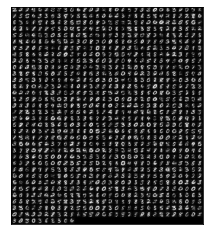

In [ ]:
# display the 1000 digits generated by GAN
show(gen_digits)

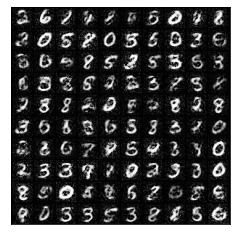

In [ ]:
# display the first 100 digits generated by GAN
show(gen_digits[:300])

In [ ]:
# load best performing FeedForwardNet model in part 2 
model = FeedForwardNet().to(device)
checkpoint = torch.load("/content/checkpoint1.pt")
model.load_state_dict(checkpoint) 

<All keys matched successfully>

In [ ]:
model_input = generated_img.view(-1, 784).to(device)
out = model(model_input) 
preds = out.argmax(dim=-1).detach().cpu().numpy() 

first_hundred_preds = np.array(preds[:100]).reshape(10,10)
print("first 100 Predicted labels of GAN generated 1000 digits by classifier:\n", 
      first_hundred_preds)

first 100 Predicted labels of GAN generated 1000 digits by classifier:
 [[2 6 8 4 8 9 5 0 4 8]
 [2 0 5 8 0 5 5 0 3 5]
 [2 0 4 8 5 2 5 3 5 3]
 [5 5 8 5 2 2 3 8 5 8]
 [2 8 8 2 2 9 7 8 2 8]
 [3 0 8 8 6 3 3 3 2 0]
 [2 3 6 7 4 5 4 3 3 0]
 [2 3 3 7 2 0 2 3 3 0]
 [8 5 0 5 8 5 3 0 5 8]
 [9 2 3 3 5 3 8 8 5 6]]


- Compare the image of first 100 digits generated by generator of GAN to the predicted labels generated by best performing Feedforward Net classifier trained in part 1 by feeding these fake images, we can see that the generator does a good job of fooling the classifier.

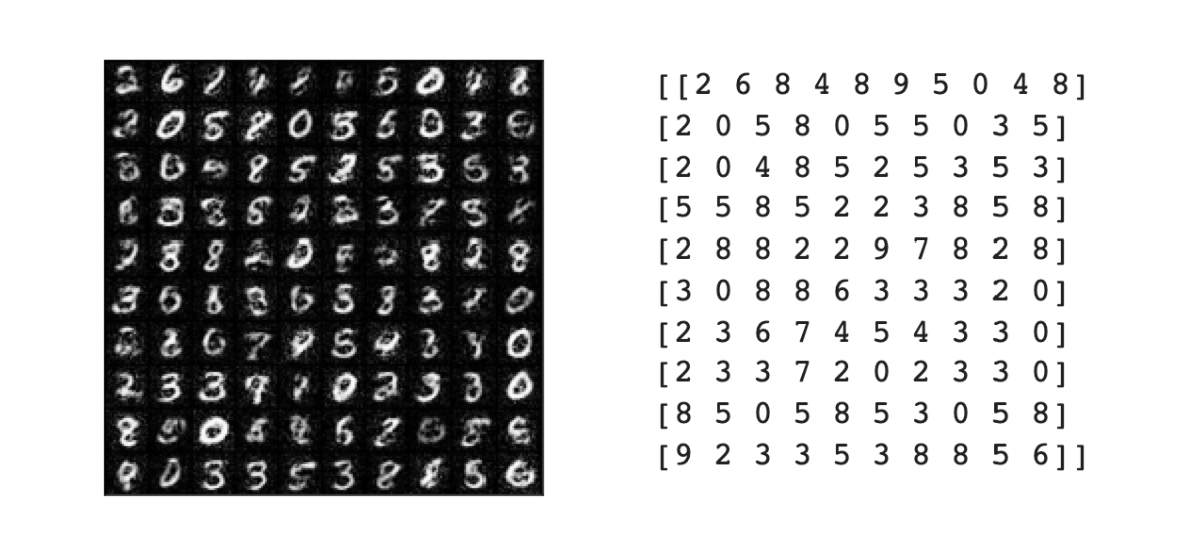

## discussion

- which generates more realistic images: GAN or VAE?


- why?

VAE generate more realistic images than GAN. Because the VAE is trained on real images, while GAN is trained on fake images generated by noise.

- Does your GAN appear to generate all digits in equal number or specialized in a smaller number of digits?


- why?

Among the generated 1000 digits, GAN tend to generate digit 8 (193 times), 3 (181 times), 5 (155 times), digit 2 (139 times), digit 0 (132 times). I'ts noticeable that digit 1 is only generated 3 times. The reason might be that the curves of these frequently generated digits are common among other digits.

# info theory

- in high dim cases, look at pictures is a subjective, infeasible method to evaluate performance of generative models

    **info theory measures** are better to evaluate generative models


- you will apply various divergence measures to various distributions,

## simple distribution

- compute divergence of 2 batches of samples drawn from 2 simple distributions

    1. sample 1k points from a 3D uniform distribution
    
    2. sample 1k points from a 3D Normal distribution N(0, 1)
 

- for each divergence, measure computation time required using `time.perf_counter` function of `time` module

    - KL divergence
    
    - Earth Mover's Distance (EMD)
    
    - Maximum Mean Discrepancy (MMD)
    

- increase variance of normal distribution to make it increasingly flat

    repeat all of above measures,
    
    remember increase range of uniform distribution to match range of normal distribution,
    
    to ensure densities are comparable

- kernel function
    
$$
K_{i, j} = e^{- \frac{\left \| X_i - Y_j \right \|^2}{2\sigma^2}}
$$

In [ ]:
def kernel(X: np.ndarray, Y: np.ndarray, sigma: float=1) -> np.ndarray:
    """
    A gaussian kernel on two arrays.
    :param 
    X: samples from distribution 1. (N, d)
    Y: samples from distribution 2. (N, d)
    sigma: kernel bandwidth
    :return 
    K:  A symmetric matrix (N, N) in which k_{i,j} = e^{-||A_i - B_j||^2/(2*sigma^2)}
    """
    n = X.shape[0]
    K = np.zeros([n, n])
    for i in range(n):
      for j in range(n):
        K[i, j] = np.exp(-(np.linalg.norm(X[i] - Y[j])/sigma)**2/2)
    return K

- Maximum Mean Discrepancy (MMD) of 2 distributions P and Q is Expected value of with-sample kernel subtracted by Expected value of cross-sample kernel

$$
\text{MMD}(P, Q) = \mathbb{E}_{x, x' \in P}k(x, x')+\mathbb{E}_{y, y' \in Q}k(y, y')-\mathbb{E}_{x \in P, y \in Q}k(x, y)
$$

In [ ]:
def MMD(X: np.ndarray, Y: np.ndarray, kernel_fn: callable, sigma: float=1):
    """
    Returns Maximum Mean Discrepancy of 2 distributions
    :param 
    X: samples from distribution 1. (N, d)
    Y: samples from distribution 2. (N, d)
    kernel_fn: a kernel function
    sigma: kernel bandwidth
    """
    mmd = np.mean(kernel_fn(X, X, sigma)) + np.mean(kernel_fn(Y, Y, sigma)) - 2*np.mean(kernel_fn(X, Y, sigma))
    return mmd

- KL divergence of 2 distributions:

$$
D_{KL}(P||Q)=-\sum_{x \in X} P(x) \log \left ( \frac{Q(x)}{P(x)} \right ) = \sum_{x \in X} P(x) \log \left ( \frac{P(x)}{Q(x)} \right )
$$

divergence isn't symmetric, so try both directions

- use `sklearn.neighbors.KernelDensity` to estimate P(x) and Q(x),

  or estimate from histogram `hist = np.histogram(data, bins=100, range=(-20,20), density=True)[0]`

- use `scipy.stats.entropy` to calculate KL Divergence

In [4]:
def KLdivergence(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Returns KL Divergence of 2 distributions 
    :param 
    X: samples from distribution 1. (N, d)
    Y: samples from distribution 2. (N, d)
    """
    densityX = np.exp(KernelDensity(kernel='gaussian', metric='euclidean').fit(X).score_samples(X))  # np.histogram(X, bins=100, density=True)[0]
    densityY = np.exp(KernelDensity(kernel='gaussian', metric='euclidean').fit(Y).score_samples(Y))
    return scipy.stats.entropy(densityX, densityY)  

- Earth Mover's Distance (EMD)

    use `PyEMD` package's `emd_samples` to compute EMD

In [ ]:
def EMD(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Returns earth mover's distance of 2 distributions
    :param 
    X: samples from distribution 1. (N, d)
    Y: samples from distribution 2. (N, d)
    """
    return emd_samples(X, Y, distance='euclidean')

# def EMD(p, q):
#     x = p - q
#     y = torch.cumsum(x, dim=0)
#     return y.abs().sum()

In [ ]:
def trial(X, Y, sigma=1):
    """
    Returns metrics comparing 2 distributions
    :param 
    X: samples from distribution 1. (N, d)
    Y: samples from distribution 2. (N, d)
    sigma: bandwidth for MMD
    """
    print('KL Divergence(X, Y): {:.5f}'.format(KLdivergence(X, Y)))
    print('KL Divergence(Y, X): {:.5f}'.format(KLdivergence(Y, X)))
    print('EMD: {:.5f}'.format(EMD(X, Y)))
    print('MMD: {:.5f}'.format(MMD(X, Y, sigma)))

### compute divergence

In [ ]:

size = (1000, 3)
# compute divergence of 2 batches of samples drawn from 2 simple distributions
for sigma in [1, 2, 3]:

  # sample 1k points from a 3D Normal distribution N(0, 1)
  a = np.random.normal(0, sigma, size=size)

  # sample 1k points from a 3D uniform distribution 
  b = np.random.uniform(low=-sigma, high=sigma, size=size)

  print(f"sigma = {sigma}")

  trial(a, b) 

# replace 0 entries of a and b to a small number 1e-8
# a[a==0] = 1e-8
# b[b==0] = 1e-8 


sigma = 1
KL Divergence(a, b): 0.13190 	 time: 0.16147
KL Divergence(b, a): 0.16369 	 time: 0.16042
EMD: 0.30119 	 time: 0.00941
MMD: 0.08205 	 time: 33.96614
sigma = 2
KL Divergence(a, b): 0.27257 	 time: 0.15953
KL Divergence(b, a): 0.34455 	 time: 0.16436
EMD: 0.63254 	 time: 0.00291
MMD: 0.04548 	 time: 33.95288
sigma = 3
KL Divergence(a, b): 0.27812 	 time: 0.15806
KL Divergence(b, a): 0.34478 	 time: 0.15821
EMD: 0.91766 	 time: 0.00231
MMD: 0.02065 	 time: 33.81540


### discussion

based on above measures along, which divergence seems most accurate?

> I think KL Divergence is most accurate. Because the discrepancy between normal distribution N(0, 1) and uniform distribution with same range should be relative small.

## MNIST Sample Distributions

- apply different divergence to real data

    1. sample 1k MNIST digits from test set
    
    2. sample a different and non-overlapping subset of 1k MNIST digits
    

- compare these will give you some idea of base value of each measure

- to avoid effect of dim and make estimating PDF feasible,

    input: run PCA on each of these subsets to reduce dim fro 784 to 8
    

- compute KLD, EMD, MMD


- repeat a few times with different sets of MNIST samples

    to get an idea of expected range for each distance

In [ ]:
mnist_test = datasets.MNIST(root = 'data', train=False, download=True,transform = transforms.ToTensor())
# use PCA to reduce dim of data from 784 to 8. data.shape (10000, 8)
data = scprep.reduce.pca(mnist_test.data.view(-1, 784).numpy(), n_components=8, method='dense')

In [ ]:
def mnist_trial(data): 

    # Returns a random permutation of integers from 0 to n-1.
    indices = torch.randperm(data.shape[0])[:2000]

    # genearte first distribution
    X = torch.utils.data.Subset(data, indices[:1000]).dataset
    
    # generate second distribution
    Y = torch.utils.data.Subset(data, indices[1000:]).dataset

    trial(X, Y) 

In [ ]:
# calculate different divergence neasures for 5 times
for i in range(5):
  mnist_trial(data)

KL Divergence(a, b): -0.00000 	 time: 0.02319
KL Divergence(b, a): 0.00000 	 time: 0.02040
EMD: 9.63460 	 time: 0.00435
MMD: 0.00200 	 time: 34.96452
KL Divergence(a, b): -0.00000 	 time: 0.01831
KL Divergence(b, a): 0.00000 	 time: 0.02318
EMD: 8.26964 	 time: 0.00387
MMD: 0.00200 	 time: 36.14374
KL Divergence(a, b): -0.00000 	 time: 0.02207
KL Divergence(b, a): 0.00000 	 time: 0.01945
EMD: 13.70314 	 time: 0.00420
MMD: 0.00200 	 time: 35.67262
KL Divergence(a, b): 0.00000 	 time: 0.03075
KL Divergence(b, a): -0.00000 	 time: 0.02219
EMD: 5.26309 	 time: 0.00398
MMD: 0.00200 	 time: 35.24130
KL Divergence(a, b): 0.00000 	 time: 0.01920
KL Divergence(b, a): -0.00000 	 time: 0.02438
EMD: 9.35590 	 time: 0.00416
MMD: 0.00200 	 time: 35.48500


## GAN Distributions

- finally, compare GAN's output to real data

    1. one of 1k MNIST digits subset from last section
    
    2. generate 1k images with your GAN (reduce tensor dim using PCA as previous)
    

- compute KLD, EMD, MMD

In [ ]:
# real images
data = scprep.reduce.pca(mnist_test.data.view(-1, 784).numpy(), n_components=8, method='dense')
indices = torch.randperm(data.shape[0])[:2000]
X = torch.utils.data.Subset(data, indices[:1000]).dataset

# generated images
Y = scprep.reduce.pca(generated_img.view(-1, 784).detach().cpu().numpy(), n_components=8, method='dense')
 
trial(X, Y, sigma=1)

KL Divergence(a, b): 0.00227 	 time: 0.14727
KL Divergence(b, a): 0.00238 	 time: 0.09775
EMD: 342.81648 	 time: 1.71971
MMD: 0.00205 	 time: 37.07747


## discussion

- which divergence or distance showed greatest discrepancy between real MNIST data and GAN?

> MMD showed greatest discrepancy between real MNIST data and GAN.

- which info measures will you recommend for judging a GAN's output?

> I would recommend EMD, because the GAN's output is pretty similar as real digits, I expect the discrepancy between real MNIST data and GAN's output be small.

- how do runtimes of these measures compare?

> The length of runtime: EMD > KL Divergence > MMD.